# Readability Assessment through Learning

* Readability assessment is a well known problem in natural language processing field. 
* Giving someone the suitable text for his level of comprehension (not so easy and not so hard) could maximize his understanding and enjoyment. 

|Rule Based System|Learning System|
|:---|:---|
|Hard to cover domain fully (a lot of if conditions)|Handles new data easily|
|Rule manintance effort|Improves without manual maintaince|

### Existing rules for readability assessment
>Flesch–Kincaid formula(1943) = 206.835 − (1.015 × ASL) − (84.6 × ASW)<br>
>Where: ASL = average sentence length (number of words divided by number of sentences)<br>
>ASW = average word length in syllables (number of syllables divided by number of words)

>The Dale–Chall formula(1995) = 0.1579*(PDW) + 0.0496*(ASL) + 3.6365<br>
>PDW = Percentage of difficult words not on the Dale–Chall word list.<br>
>ASL = Average sentence length

In this notebook we are trying to assess the readability of a given text regardless of the text topic.

## Corpus
> OneStopEnglish corpus: A new corpus for automatic readability assessment and text simplification  
> Sowmya Vajjala and Ivana Lučić  
> 2018  
> Proceedings of the Thirteenth Workshop on Innovative Use of NLP for Building Educational Applications, pages 297–304. Association for Computational Linguistics.  
> [url](http://aclweb.org/anthology/W18-0535). [bib file](https://aclanthology.coli.uni-saarland.de/papers/W18-0535/w18-0535.bib)

Please cite the above paper if you use this corpus in your research.

[![DOI](https://zenodo.org/badge/128919409.svg)](https://zenodo.org/badge/latestdoi/128919409)

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

Now let's dive into our corpus.

In [1]:
import sys
sys.path.append("/home/ms10596/PycharmProjects/match")
from ipywidgets import interact
from tabulate import tabulate
from IPython.display import display, HTML

from utils.loading import load_glove_embeddings
from utils.one_stop_english import load_corpus, corpus_to_words, corpus_to_pos, detokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional,Conv1D,MaxPooling1D,GlobalMaxPooling1D, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np

corpus = load_corpus()
articles_words, tags = corpus_to_words(corpus)
articles_pos, tags = corpus_to_pos(corpus)

Reading level|Avg. Num. Words|Std. Dev|Number of Articles
---|---|---|---
Elementary|533.17|103.79|189
Intermediate|676.59|117.15|189
Advanced|820.49|162.52|189



In [2]:
@interact
def show_articles(i=(0,188,1), words=(0,1000,1)):
    data = [
        ["Advanced",detokenize(articles_words[i][:words])], 
        ["Intermediate",detokenize(articles_words[i+2][:words])], 
        ["Elementary",detokenize(articles_words[i+1][:words])]
    ]
    headers = ['Reading Level', 'Example']
    display(HTML(tabulate(data,tablefmt='html', headers=headers)+"<style>th,td {font-size: 20px}</style>"))

interactive(children=(IntSlider(value=94, description='i', max=188), IntSlider(value=500, description='words',…

In [3]:
print(articles_words[0][:10])
print(articles_pos[0][:10])

['When', 'you', 'see', 'the', 'word', 'Amazon', ',', 'whats', 'the', 'first']
['WRB', 'PRP', 'VB', 'DT', 'NN', 'NN', ',', 'VBZ', 'DT', 'JJ']


In [4]:
import json
maxlen = 1000 # Cuts off reviews after 1000 words
max_words = 45
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(articles_pos)

with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer.to_json(), ensure_ascii=False))
print(tokenizer.word_index)

{'nn': 1, 'in': 2, 'dt': 3, 'jj': 4, 'nns': 5, 'nnp': 6, ',': 7, '.': 8, 'rb': 9, 'prp': 10, 'vb': 11, 'vbd': 12, 'cc': 13, 'vbz': 14, 'to': 15, 'vbp': 16, 'cd': 17, 'vbn': 18, 'vbg': 19, 'prp$': 20, 'md': 21, 'wdt': 22, 'wrb': 23, 'wp': 24, 'jjr': 25, 'rp': 26, ':': 27, 'jjs': 28, 'ex': 29, 'rbr': 30, 'nnps': 31, '-rrb-': 32, '-lrb-': 33, 'rbs': 34, 'pdt': 35, '$': 36, 'fw': 37, 'uh': 38, 'wp$': 39, 'sym': 40, "''": 41, 'ls': 42, 'pos': 43, '``': 44}


In [5]:
sequences = tokenizer.texts_to_sequences(articles_pos)
print(np.shape(sequences))
print(sequences[0])

(567,)
[23, 10, 11, 3, 1, 1, 7, 14, 3, 4, 1, 22, 14, 15, 11, 3, 4, 28, 1, 7, 3, 28, 1, 13, 3, 28, 1, 1, 13, 22, 16, 10, 16, 34, 4, 8, 3, 5, 16, 18, 15, 3, 1, 2, 3, 4, 7, 13, 9, 4, 7, 1, 2, 23, 15, 11, 3, 5, 2, 3, 1, 8, 6, 13, 6, 16, 18, 5, 15, 3, 1, 18, 2, 3, 6, 4, 1, 2, 3, 4, 4, 1, 2, 1, 27, 8, 11, 8, 3, 4, 1, 14, 18, 2, 20, 1, 15, 11, 3, 4, 1, 1, 19, 9, 8, 4, 32, 7, 13, 3, 6, 6, 5, 16, 3, 21, 11, 3, 1, 2, 3, 1, 1, 2, 4, 1, 7, 3, 1, 2, 4, 5, 13, 4, 4, 1, 14, 8, 9, 2, 5, 2, 4, 4, 5, 15, 5, 7, 19, 8, 6, 6, 8, 4, 7, 3, 1, 14, 15, 3, 1, 2, 5, 2, 3, 1, 13, 1, 2, 3, 1, 8, 2, 9, 7, 3, 5, 2, 4, 7, 4, 13, 4, 5, 2, 1, 12, 9, 4, 2, 3, 1, 1, 2, 8, 1, 14, 8, 1, 13, 17, 4, 5, 8, 13, 3, 5, 13, 4, 4, 5, 33, 5, 32, 2, 10, 16, 9, 18, 16, 2, 15, 11, 3, 28, 1, 2, 3, 1, 2, 3, 4, 1, 8, 3, 6, 6, 2, 6, 31, 13, 31, 33, 6, 32, 3, 4, 4, 1, 22, 14, 3, 4, 1, 2, 1, 1, 14, 18, 5, 33, 3, 9, 4, 9, 36, 17, 32, 2, 5, 2, 4, 5, 15, 11, 15, 3, 4, 17, 8, 6, 14, 18, 2, 5, 2, 4, 5, 7, 19, 8, 1, 14, 8, 1, 14, 8, 1, 11, 8, 11,

In [6]:
data = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
print(data[0])
print(np.shape(data))

[23 10 11  3  1  1  7 14  3  4  1 22 14 15 11  3  4 28  1  7  3 28  1 13
  3 28  1  1 13 22 16 10 16 34  4  8  3  5 16 18 15  3  1  2  3  4  7 13
  9  4  7  1  2 23 15 11  3  5  2  3  1  8  6 13  6 16 18  5 15  3  1 18
  2  3  6  4  1  2  3  4  4  1  2  1 27  8 11  8  3  4  1 14 18  2 20  1
 15 11  3  4  1  1 19  9  8  4 32  7 13  3  6  6  5 16  3 21 11  3  1  2
  3  1  1  2  4  1  7  3  1  2  4  5 13  4  4  1 14  8  9  2  5  2  4  4
  5 15  5  7 19  8  6  6  8  4  7  3  1 14 15  3  1  2  5  2  3  1 13  1
  2  3  1  8  2  9  7  3  5  2  4  7  4 13  4  5  2  1 12  9  4  2  3  1
  1  2  8  1 14  8  1 13 17  4  5  8 13  3  5 13  4  4  5 33  5 32  2 10
 16  9 18 16  2 15 11  3 28  1  2  3  1  2  3  4  1  8  3  6  6  2  6 31
 13 31 33  6 32  3  4  4  1 22 14  3  4  1  2  1  1 14 18  5 33  3  9  4
  9 36 17 32  2  5  2  4  5 15 11 15  3  4 17  8  6 14 18  2  5  2  4  5
  7 19  8  1 14  8  1 14  8  1 11  8 11  8 13 20 34  4  1 14  2 20  4  1
  8  6 13  6 16 18  2  3  8  1  1 15 11 18  7 19  3

In [7]:
print(tags[0])
tags = np.array(tags)
print(tags.shape)

2
(567,)


In [8]:
data = to_categorical(data)
print(data.shape)
print(data[0])

(567, 1000, 45)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [9]:
np.random.seed(0)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
tags = tags[indices]
print(data.shape)
print(tags.shape)

(567, 1000, 45)
(567,)


In [21]:
model = Sequential()
model.add(Conv1D(128, 5, activation='relu',kernel_regularizer=l1_l2(l1=0.01, l2=0.01), input_shape=(1000,45)))
model.add(MaxPooling1D(5))
model.add(Conv1D(64, 5, activation='relu',kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 5, activation='relu',kernel_regularizer=l1_l2(l1=0.0003, l2=0.0003)))
model.add(GlobalMaxPooling1D())
model.add(Dense(1))
# model.summary()
def soft_acc(y_true, y_pred):
    from tensorflow.python.keras import backend as K
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

In [134]:
es = EarlyStopping(monitor='val_soft_acc',patience=100, mode='max')
cp = ModelCheckpoint('model-{epoch:03d}-{soft_acc:03f}-{val_soft_acc:03f}.h5', verbose=1, monitor='val_soft_acc',save_best_only=True, mode='max')  
model.compile(optimizer=RMSprop(),loss='mse',metrics=[soft_acc])
history = model.fit(data, tags,epochs=1000,  batch_size=50,validation_split=0.2,callbacks=[es, cp])
# model.save_weights('pre_trained_glove_model.h5')
model.summary()

Train on 453 samples, validate on 114 samples
Epoch 1/1000
450/453 [============================>.] - ETA: 0s - loss: 13.0836 - soft_acc: 0.3667
Epoch 00001: val_soft_acc improved from -inf to 0.30702, saving model to model-001-0.366446-0.307018.h5
453/453 [==============================] - 5s 10ms/step - loss: 13.0685 - soft_acc: 0.3664 - val_loss: 10.6317 - val_soft_acc: 0.3070
Epoch 2/1000
450/453 [============================>.] - ETA: 0s - loss: 9.5323 - soft_acc: 0.3511
Epoch 00002: val_soft_acc did not improve from 0.30702
453/453 [==============================] - 0s 657us/step - loss: 9.5263 - soft_acc: 0.3488 - val_loss: 8.1700 - val_soft_acc: 0.3070
Epoch 3/1000
450/453 [============================>.] - ETA: 0s - loss: 7.2675 - soft_acc: 0.3978
Epoch 00003: val_soft_acc improved from 0.30702 to 0.49123, saving model to model-003-0.399558-0.491228.h5
453/453 [==============================] - 0s 713us/step - loss: 7.2626 - soft_acc: 0.3996 - val_loss: 6.2503 - val_soft_acc: 

Epoch 29/1000
450/453 [============================>.] - ETA: 0s - loss: 0.8153 - soft_acc: 0.4822
Epoch 00029: val_soft_acc did not improve from 0.50000
453/453 [==============================] - 0s 659us/step - loss: 0.8167 - soft_acc: 0.4812 - val_loss: 1.0327 - val_soft_acc: 0.3860
Epoch 30/1000
450/453 [============================>.] - ETA: 0s - loss: 0.8419 - soft_acc: 0.4533
Epoch 00030: val_soft_acc did not improve from 0.50000
453/453 [==============================] - 0s 654us/step - loss: 0.8395 - soft_acc: 0.4547 - val_loss: 0.7867 - val_soft_acc: 0.4912
Epoch 31/1000
450/453 [============================>.] - ETA: 0s - loss: 0.7790 - soft_acc: 0.4778
Epoch 00031: val_soft_acc did not improve from 0.50000
453/453 [==============================] - 0s 646us/step - loss: 0.7798 - soft_acc: 0.4746 - val_loss: 0.7967 - val_soft_acc: 0.4912
Epoch 32/1000
450/453 [============================>.] - ETA: 0s - loss: 0.7858 - soft_acc: 0.4667
Epoch 00032: val_soft_acc did not improv

Epoch 86/1000
450/453 [============================>.] - ETA: 0s - loss: 0.6823 - soft_acc: 0.5133
Epoch 00086: val_soft_acc did not improve from 0.64912
453/453 [==============================] - 0s 638us/step - loss: 0.6803 - soft_acc: 0.5166 - val_loss: 0.7870 - val_soft_acc: 0.4561
Epoch 87/1000
450/453 [============================>.] - ETA: 0s - loss: 0.6817 - soft_acc: 0.4844
Epoch 00087: val_soft_acc did not improve from 0.64912
453/453 [==============================] - 0s 641us/step - loss: 0.6792 - soft_acc: 0.4879 - val_loss: 0.6811 - val_soft_acc: 0.4912
Epoch 88/1000
450/453 [============================>.] - ETA: 0s - loss: 0.6678 - soft_acc: 0.4933
Epoch 00088: val_soft_acc did not improve from 0.64912
453/453 [==============================] - 0s 637us/step - loss: 0.6707 - soft_acc: 0.4901 - val_loss: 1.0491 - val_soft_acc: 0.4211
Epoch 89/1000
450/453 [============================>.] - ETA: 0s - loss: 0.7218 - soft_acc: 0.4600
Epoch 00089: val_soft_acc did not improv

Epoch 115/1000
450/453 [============================>.] - ETA: 0s - loss: 0.6468 - soft_acc: 0.4822
Epoch 00115: val_soft_acc did not improve from 0.64912
453/453 [==============================] - 0s 622us/step - loss: 0.6451 - soft_acc: 0.4834 - val_loss: 0.6677 - val_soft_acc: 0.5526
Epoch 116/1000
450/453 [============================>.] - ETA: 0s - loss: 0.6471 - soft_acc: 0.5178
Epoch 00116: val_soft_acc did not improve from 0.64912
453/453 [==============================] - 0s 626us/step - loss: 0.6492 - soft_acc: 0.5166 - val_loss: 0.6688 - val_soft_acc: 0.4825
Epoch 117/1000
450/453 [============================>.] - ETA: 0s - loss: 0.6410 - soft_acc: 0.4933
Epoch 00117: val_soft_acc did not improve from 0.64912
453/453 [==============================] - 0s 635us/step - loss: 0.6391 - soft_acc: 0.4945 - val_loss: 0.7900 - val_soft_acc: 0.5789
Epoch 118/1000
450/453 [============================>.] - ETA: 0s - loss: 0.6565 - soft_acc: 0.5267
Epoch 00118: val_soft_acc did not im

Epoch 172/1000
450/453 [============================>.] - ETA: 0s - loss: 0.6089 - soft_acc: 0.5600
Epoch 00172: val_soft_acc did not improve from 0.67544
453/453 [==============================] - 0s 645us/step - loss: 0.6075 - soft_acc: 0.5607 - val_loss: 0.7010 - val_soft_acc: 0.6140
Epoch 173/1000
450/453 [============================>.] - ETA: 0s - loss: 0.6018 - soft_acc: 0.6178
Epoch 00173: val_soft_acc did not improve from 0.67544
453/453 [==============================] - 0s 651us/step - loss: 0.6009 - soft_acc: 0.6181 - val_loss: 0.6378 - val_soft_acc: 0.4825
Epoch 174/1000
450/453 [============================>.] - ETA: 0s - loss: 0.6068 - soft_acc: 0.5778
Epoch 00174: val_soft_acc did not improve from 0.67544
453/453 [==============================] - 0s 657us/step - loss: 0.6050 - soft_acc: 0.5806 - val_loss: 0.5951 - val_soft_acc: 0.6228
Epoch 175/1000
450/453 [============================>.] - ETA: 0s - loss: 0.5971 - soft_acc: 0.5844
Epoch 00175: val_soft_acc did not im

Epoch 229/1000
450/453 [============================>.] - ETA: 0s - loss: 0.5058 - soft_acc: 0.7267
Epoch 00229: val_soft_acc did not improve from 0.73684
453/453 [==============================] - 0s 652us/step - loss: 0.5059 - soft_acc: 0.7263 - val_loss: 0.6598 - val_soft_acc: 0.6404
Epoch 230/1000
450/453 [============================>.] - ETA: 0s - loss: 0.4957 - soft_acc: 0.7311
Epoch 00230: val_soft_acc did not improve from 0.73684
453/453 [==============================] - 0s 661us/step - loss: 0.4957 - soft_acc: 0.7285 - val_loss: 0.8995 - val_soft_acc: 0.4211
Epoch 231/1000
450/453 [============================>.] - ETA: 0s - loss: 0.5392 - soft_acc: 0.7111
Epoch 00231: val_soft_acc did not improve from 0.73684
453/453 [==============================] - 0s 648us/step - loss: 0.5380 - soft_acc: 0.7130 - val_loss: 0.7893 - val_soft_acc: 0.5175
Epoch 232/1000
450/453 [============================>.] - ETA: 0s - loss: 0.5096 - soft_acc: 0.7244
Epoch 00232: val_soft_acc did not im

Epoch 258/1000
450/453 [============================>.] - ETA: 0s - loss: 0.5070 - soft_acc: 0.7111
Epoch 00258: val_soft_acc did not improve from 0.73684
453/453 [==============================] - 0s 676us/step - loss: 0.5081 - soft_acc: 0.7108 - val_loss: 0.6599 - val_soft_acc: 0.4737
Epoch 259/1000
450/453 [============================>.] - ETA: 0s - loss: 0.4907 - soft_acc: 0.7333
Epoch 00259: val_soft_acc did not improve from 0.73684
453/453 [==============================] - 0s 683us/step - loss: 0.4897 - soft_acc: 0.7351 - val_loss: 0.6793 - val_soft_acc: 0.4298
Epoch 260/1000
450/453 [============================>.] - ETA: 0s - loss: 0.4788 - soft_acc: 0.7600
Epoch 00260: val_soft_acc did not improve from 0.73684
453/453 [==============================] - 0s 691us/step - loss: 0.4782 - soft_acc: 0.7616 - val_loss: 0.6161 - val_soft_acc: 0.6754
Epoch 261/1000
450/453 [============================>.] - ETA: 0s - loss: 0.4792 - soft_acc: 0.7489
Epoch 00261: val_soft_acc did not im

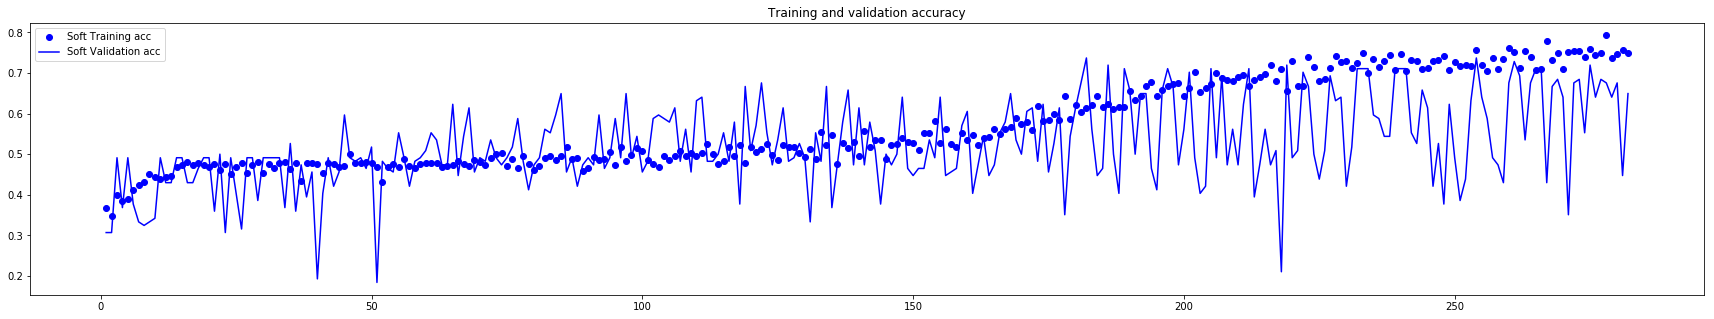

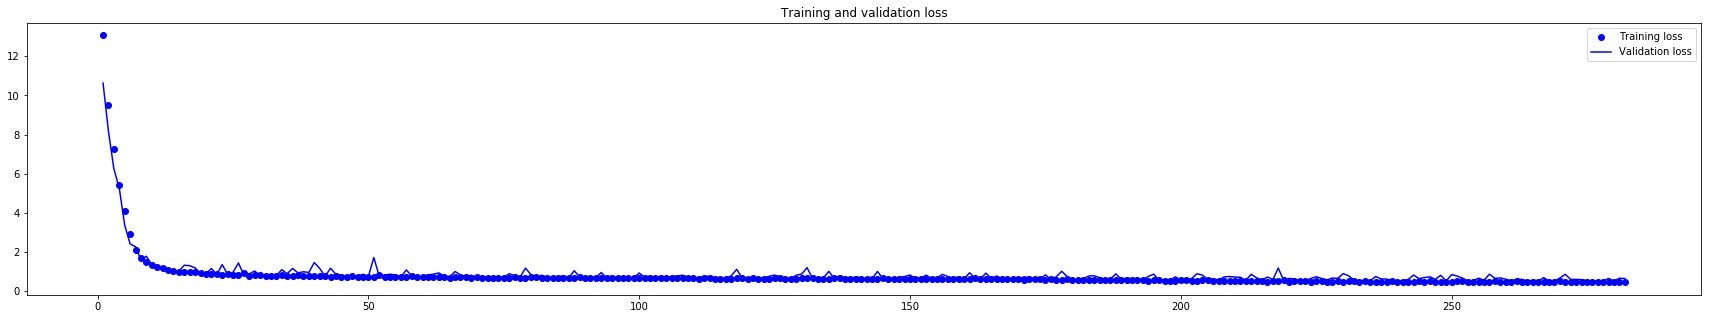

In [135]:
import matplotlib.pyplot as plt

soft_acc = history.history['soft_acc']
soft_val_acc = history.history['val_soft_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(soft_acc) + 1)
plt.figure(figsize=(30,5))
plt.plot(epochs, soft_acc, 'bo', label='Soft Training acc')
plt.plot(epochs, soft_val_acc, 'b', label='Soft Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure(figsize=(30,5))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()




In [22]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, shuffle=True)
cvs_scores = []
for train, test in kfold.split(data, tags):
    model.compile(optimizer=RMSprop(),loss='mse',metrics=[soft_acc])
    model.fit(data[train], tags[train], epochs=1000, verbose=0)
    scores = model.evaluate(data[test], tags[test], verbose=0)
    print(scores[1]*100)
    cvs_scores.append(scores[1]*100)
print("Accuracy:", np.mean(cvs_scores),"std:", np.std(cvs_scores))

45.614034251162884
73.68421010803759
68.42105221330074
77.19298203786215
80.70175490881267
68.42105388641357
78.94736727078757
77.19298224700125
80.70175490881267
66.66666754969845
Accuracy: 71.75438593818896 std: 10.030731594091595
